# Images

Images are always tricky to manage in classical environments but really complex structures have been leveraged lately that provide really impressive results in difficult scenarios (cancer detection in breast radiography for example).

In [1]:
import medmnist
from medmnist import INFO

info = INFO['breastmnist']
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist,info['python_class'])

print('The number of classe are: ', n_classes,'\nAnd the number of channels: ', n_channels, '\nAnd the task is: ',task)

The number of classe are:  2 
And the number of channels:  1 
And the task is:  binary-class


In [ ]:
# load the data
train_dataset = DataClass(split='train', download=True)
test_dataset = DataClass(split='test', download=True)

In [3]:
import numpy as np

n_train = 546   # Size of the train dataset
n_test = 156    # Size of the test dataset

# Reshape the images
train_imgs_tf = np.reshape(train_dataset.imgs[:n_train], (n_train,28,28,1))
test_imgs_tf = np.reshape(test_dataset.imgs[:n_test], (n_test,28,28,1))

# Load the labels
train_labels_tf = np.reshape(train_dataset.labels[:n_train], (n_train,))
test_labels_tf = np.reshape(test_dataset.labels[:n_test], (n_test,))

# Reduce dataset size
train_imgs_tf = train_imgs_tf[:n_train]
train_labels_tf = train_labels_tf[:n_train]
test_imgs_tf = test_imgs_tf[:n_test]
test_labels_tf = test_labels_tf[:n_test]

# Normalize pixel values within 0 and 1
train_imgs_tf = (train_imgs_tf / 255)*np.pi
test_imgs_tf = (test_imgs_tf / 255)*np.pi

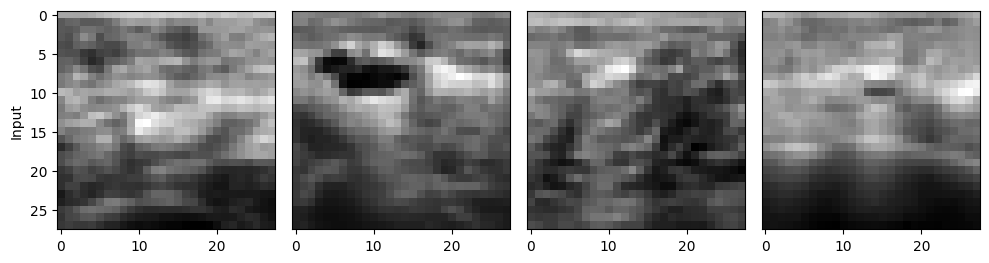

In [4]:
import matplotlib.pyplot as plt

n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0].set_ylabel("Input")
    if k != 0:
        axes[k].yaxis.set_visible(False)
    axes[k].imshow(train_imgs_tf[k, :, :, 0], cmap="gray")

plt.tight_layout()
plt.show()

Can you tell which one has cancer? Me neither. Let's see if the model can. We will create a simple funnel type of architecture down to the two classes we would like to be detected.

In [5]:
import warnings

from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier

# Reshape the dimensions
train_imgs_tf = train_imgs_tf.reshape(546,28*28)
test_imgs_tf = test_imgs_tf.reshape(156,28*28)

# Build model
mlp = MLPClassifier(
    hidden_layer_sizes=(250, 50, 10),
    max_iter=8,
    alpha=1e-4,
    solver="sgd",
    verbose=10,
    random_state=1,
    learning_rate_init=0.01,
)

# this example won't converge because of resource usage constraints on
# our Continuous Integration infrastructure, so we catch the warning and
# ignore it here
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    mlp.fit(train_imgs_tf, train_labels_tf)

print("Training set score: %f" % mlp.score(train_imgs_tf, train_labels_tf))

Iteration 1, loss = 0.65528992
Iteration 2, loss = 0.56395755
Iteration 3, loss = 0.52825156
Iteration 4, loss = 0.50769647
Iteration 5, loss = 0.49627175
Iteration 6, loss = 0.49639649
Iteration 7, loss = 0.48041723
Iteration 8, loss = 0.47358274
Training set score: 0.791209


In [6]:
print("Test set score: %f" % mlp.score(test_imgs_tf, test_labels_tf))

Test set score: 0.807692


Not bad. We could also look for the classification report.

In [30]:
from sklearn.metrics import classification_report

y_test = mlp.predict(test_imgs_tf)
print(classification_report(y_test, test_labels_tf))

              precision    recall  f1-score   support

           0       0.45      0.73      0.56        26
           1       0.94      0.82      0.88       130

    accuracy                           0.81       156
   macro avg       0.70      0.78      0.72       156
weighted avg       0.86      0.81      0.82       156



Now we would like to check if quantum can help at any point discriminating better between our two classes.

In [31]:
from qiskit.quantum_info import SparsePauliOp

# Generate an observable
observable = SparsePauliOp("ZIII") + SparsePauliOp("IZII") + SparsePauliOp("IIZI") + SparsePauliOp("IIIZ")

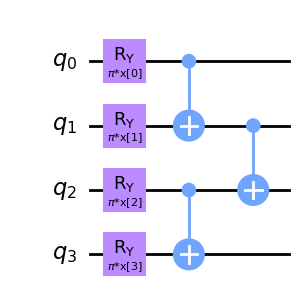

In [32]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
from squlearn.encoding_circuit.layered_encoding_circuit import LayeredEncodingCircuit

# Empty LayeredEncodingCircuit with 4 qubits and a one-dimensional input
lfm = LayeredEncodingCircuit(num_qubits=4, num_features=4)

def multiply_pi(x):
    return x * np.pi

# Create the encoding circuit via gate operations
lfm.Ry("x", encoding=multiply_pi)
lfm.cx_entangling(ent_strategy="NN") # AA

lfm.draw("mpl")

In [33]:
from squlearn.util import Executor

executor = Executor("statevector_simulator")

# Get the Executor Estimator Primitive and call run:
estimator = executor.get_estimator()

def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            circ = lfm.get_circuit(features=[
                    image[j, k],
                    image[j, k + 1],
                    image[j + 1, k],
                    image[j + 1, k + 1]
                ], parameters=None)
            result = estimator.run(circ, observable, shots=1024).result()
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2] = result.values[0]
    return out

In [29]:
train_imgs_tf = train_imgs_tf.reshape(546,28, 28)

q_train_images = []
print("Quantum pre-processing of train images:")
for idx, img in enumerate(train_imgs_tf):
    print("{}/{}        ".format(idx + 1, len(train_imgs_tf)), end="\r")
    q_train_images.append(quanv(img))
q_train_images = np.asarray(q_train_images)

# Save pre-processed images
np.save("q_train_images.npy", q_train_images)

Quantum pre-processing of train images:


Saving the results may help us when classical model needs to be modified and data is not needed to be processed again.

In [34]:
q_train_images = np.load("q_train_images.npy")

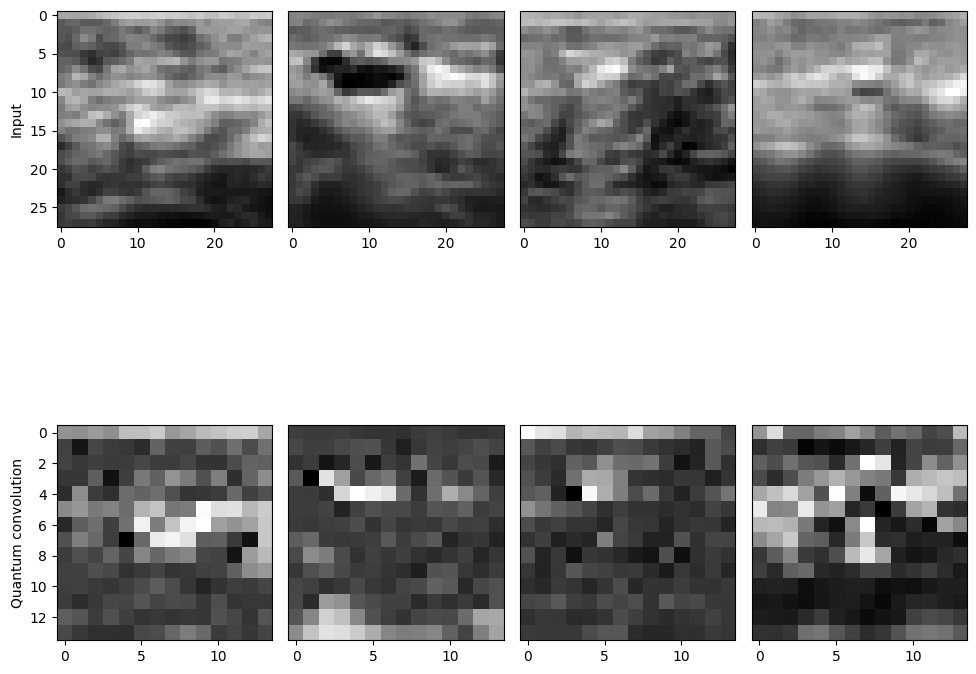

In [43]:
import matplotlib.pyplot as plt

# Reshape
train_imgs_tf = train_imgs_tf.reshape(546,28, 28, 1)

n_samples = 4
fig, axes = plt.subplots(2, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_imgs_tf[k, :, :, 0], cmap="gray")

    # Plot all output channels
    axes[1, 0].set_ylabel("Quantum convolution")
    if k != 0:
        axes[1, k].yaxis.set_visible(False)
    axes[1, k].imshow(q_train_images[k, :, :], cmap="gray")

plt.tight_layout()
plt.show()

In [44]:
q_X_train = q_train_images.reshape(546, 14*14)

mlp = MLPClassifier(
    hidden_layer_sizes=(250, 50, 10),
    max_iter=8,
    alpha=1e-4,
    solver="sgd",
    verbose=10,
    random_state=1,
    learning_rate_init=0.01,
)

# this example won't converge because of resource usage constraints on
# our Continuous Integration infrastructure, so we catch the warning and
# ignore it here
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    mlp.fit(q_X_train, train_labels_tf)

print("Training set score: %f" % mlp.score(q_X_train, train_labels_tf))

Iteration 1, loss = 0.61367553
Iteration 2, loss = 0.58990726
Iteration 3, loss = 0.56802659
Iteration 4, loss = 0.55083711
Iteration 5, loss = 0.53580084
Iteration 6, loss = 0.52001059
Iteration 7, loss = 0.50496205
Iteration 8, loss = 0.48708556
Training set score: 0.774725


In [31]:
test_imgs_tf = test_imgs_tf.reshape(156,28, 28)

q_test_images = []
print("Quantum pre-processing of train images:")
for idx, img in enumerate(test_imgs_tf):
    print("{}/{}        ".format(idx + 1, len(test_imgs_tf)), end="\r")
    q_test_images.append(quanv(img))
q_test_images = np.asarray(q_test_images)

# Save pre-processed images
np.save("q_test_images.npy", q_test_images)

Quantum pre-processing of train images:


Same as with the training dataset.

In [45]:
q_test_images = np.load("q_test_images.npy")

In [46]:
q_X_test = q_test_images.reshape(156, 14*14)

print("Test set score: %f" % mlp.score(q_X_test, test_labels_tf))

Test set score: 0.724359


In [47]:
y_test = mlp.predict(q_X_test)
print(classification_report(y_test, test_labels_tf))

              precision    recall  f1-score   support

           0       0.07      0.43      0.12         7
           1       0.96      0.74      0.84       149

    accuracy                           0.72       156
   macro avg       0.52      0.58      0.48       156
weighted avg       0.92      0.72      0.80       156



Well, we would need to see if there is a point where Quantum Convolutions enhance the behavior of their classical counterparts because this simplistic attempt biased even more our results.